In [1]:
import warnings
warnings.filterwarnings("ignore")

import os, pandas as pd, matplotlib.pyplot as plt, numpy as np, seaborn as sns, scipy.stats as stats, glob
from pynwb import NWBHDF5IO
from pathlib import Path
from convnwb.io import load_nwbfile

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import phate
from scipy.interpolate import interp1d

## confirm number of subjects, neurons, trials

In [2]:
# norm_choice = 'shortest_baseline'
# norm_choice = 'session_baseline'
norm_choice = 'self'
# norm_choice = 'nothing'
print(f'df normalized by {norm_choice}\n')

df = pd.read_pickle(f'./data_files/neuron_by_trial_norm_by_{norm_choice}.pkl')
print(f'{df["neuron"].nunique()} total neurons\n')

# identify neurons with zero firing rate in encoding or baseline
zero_FR_neurons = df[(df['FR'] == 0) & (df['stim_phase'].isin(['encoding', 'baseline']))]['neuron'].unique()
print(f'{len(zero_FR_neurons)} neurons dropped because FR = 0 in encoding or baseline: {zero_FR_neurons}\n')

# drop these neurons
df_filtered = df[~df['neuron'].isin(zero_FR_neurons)]
df_encoding = df_filtered[df_filtered['stim_phase'] == 'encoding']
num_subjs, num_sess, num_neurons = len(np.unique(df_encoding['subj'])), len(np.unique(df_encoding['sess'])), len(np.unique(df_encoding['neuron']))

print(f'{num_neurons} neurons, {num_sess} sessions, {num_subjs} subjects')
print(f'{len(df_encoding)} rows in df\n')

no_fMRI_subjs = ['P49', 'P55', 'P56', 'P57', 'P58']
print(f'subjs who didnt undergo fMRI: {no_fMRI_subjs}\n')

scene_cells = ['P42CS_R1_47_2_1347_7', 'P42CS_R2_42_3_1096_7', 'P43CS_R1_59_3_1929_1', 'P43CS_R1_76_4_1276_10', 'P43CS_R2_29_1_2303_2',
               'P44CS_R1_15_2_835_8', 'P47CS_R1_10_2_900_8', 'P47CS_R1_18_1_1631_4', 'P47CS_R1_22_4_1379_4', 'P47CS_R1_68_1_964_9',
               'P47CS_R1_74_2_1575_10', 'P47CS_R1_78_1_2233_10', 'P47CS_R2_19_2_3139_4', 'P47CS_R2_20_4_2437_4', 'P47CS_R2_47_1_1478_7',
               'P48CS_R1_9_1_678_8', 'P48CS_R1_21_2_873_4', 'P48CS_R1_30_1_1720_2', 'P48CS_R1_43_2_3181_7', 'P48CS_R2_48_2_936_7',
               'P48CS_R2_58_8_6571_1', 'P49CS_R1_7_1_2581_6', 'P49CS_R2_67_1_1165_10', 'P51CS_R1_48_1_2072_8', 'P51CS_R2_40_3_2542_5',
               'P51CS_R2_80_1_794_9', 'P53CS_R1_10_1_2456_8', 'P53CS_R2_6_4_5480_6', 'P53CS_R2_16_2_6444_8', 'P54CS_R1_17_2_3943_4',
               'P54CS_R1_45_1_2172_7', 'P54CS_R1_54_3_4177_3', 'P54CS_R1_55_2_6861_3', 'P54CS_R1_56_1_1540_3', 'P54CS_R1_70_3_5181_10',
               'P54CS_R2_13_4_7736_8', 'P54CS_R2_67_1_4703_10', 'P55CS_R2_18_2_1050_4', 'P55CS_R2_45_1_1206_7', 'P55CS_R2_48_1_36_7',
               'P56CS_R1_9_1_3423_8', 'P56CS_R1_13_1_999_8', 'P56CS_R1_19_1_1458_4', 'P57CS_R1_66_1_2442_10', 'P57CS_R2_9_1_740_8',
               'P57CS_R2_15_2_1738_8', 'P57CS_R2_70_2_1978_10', 'P58CS_R1_34_3_3299_5', 'P58CS_R1_34_4_3301_5', 'P58CS_R1_35_4_2476_5',
               'P58CS_R1_56_1_3134_3', 'P58CS_R1_57_3_2783_1', 'P58CS_R1_60_1_1424_1', 'P58CS_R1_62_2_3305_1', 'P58CS_R1_63_2_3170_1',
               'P60CS_R1_39_1_1408_5', 'P60CS_R1_54_1_571_3', 'P60CS_R1_56_1_1106_3', 'P62CS_R1_30_3_6240_3', 'P62CS_R2_22_2_2532_7']

sessions_with_scene_cells = np.unique([cell[:8] for cell in scene_cells])
print(f'{len(sessions_with_scene_cells)} sessions with scene cells: {sessions_with_scene_cells}\n')

print(f'{len(scene_cells)} scene selective cells')

df_encoding.head()


df normalized by self

1457 total neurons

19 neurons dropped because FR = 0 in encoding or baseline: ['P43CS_R2_76_1_990_10' 'P47CS_R1_19_4_1280_4' 'P47CS_R1_52_1_298_3'
 'P47CS_R2_22_1_8375_4' 'P48CS_R1_24_1_2297_4' 'P48CS_R1_57_1_753_1'
 'P48CS_R2_58_3_6420_1' 'P48CS_R2_62_2_2097_1' 'P49CS_R2_64_1_4257_1'
 'P51CS_R2_48_4_5337_7' 'P53CS_R1_37_1_3731_5' 'P54CS_R1_70_2_5145_10'
 'P54CS_R2_31_1_2534_2' 'P55CS_R1_49_2_5469_3' 'P55CS_R1_54_1_3978_3'
 'P57CS_R2_51_1_624_3' 'P62CS_R1_27_3_8498_3' 'P62CS_R1_29_3_8468_3'
 'P62CS_R1_32_6_6115_3']

1438 neurons, 29 sessions, 16 subjects
1438 rows in df

subjs who didnt undergo fMRI: ['P49', 'P55', 'P56', 'P57', 'P58']

25 sessions with scene cells: ['P42CS_R1' 'P42CS_R2' 'P43CS_R1' 'P43CS_R2' 'P44CS_R1' 'P47CS_R1'
 'P47CS_R2' 'P48CS_R1' 'P48CS_R2' 'P49CS_R1' 'P49CS_R2' 'P51CS_R1'
 'P51CS_R2' 'P53CS_R1' 'P53CS_R2' 'P54CS_R1' 'P54CS_R2' 'P55CS_R2'
 'P56CS_R1' 'P57CS_R1' 'P57CS_R2' 'P58CS_R1' 'P60CS_R1' 'P62CS_R1'
 'P62CS_R2']

60 scene selective 

subj      sess                neuron    region  start_time  stop_time  \
0    P41  P41CS_R1   P41CS_R1_21_1_679_4  amygdala         0.0  478.85512   
42   P41  P41CS_R1   P41CS_R1_38_1_613_5       ACC         0.0  478.85512   
84   P41  P41CS_R1  P41CS_R1_39_1_1359_5       ACC         0.0  478.85512   
126  P41  P41CS_R1  P41CS_R1_40_1_2816_5       ACC         0.0  478.85512   
168  P41  P41CS_R1  P41CS_R1_40_2_2821_5       ACC         0.0  478.85512   

            RT                                       trial_spikes  \
0    478.85512  [3.43207675, 4.39507675, 5.16801325, 5.2624507...   
42   478.85512  [0.2510465, 2.07970175, 4.70126325, 5.09220075...   
84   478.85512  [0.3880465, 1.5347965, 1.61257775, 2.0414215, ...   
126  478.85512  [0.0642965, 0.80051525, 0.813359, 0.89145275, ...   
168  478.85512  [0.4351715, 0.88882775, 1.79107775, 3.7156705,...   

                                  trial_aligned_spikes  num_spikes        FR  \
0    [3.43207675, 4.39507675, 5.16801325, 5.2624507...         360  0.751793   
42   [0.2510465, 2.07970175, 4.70126325, 5.09220075...         278  0.580551   
84   [0.3880465, 1.5347965, 1.61257775, 2.0414215, ...         949  1.981810   
126  [0.0642965, 0.80051525, 0.813359, 0.89145275, ...        1820  3.800732   
168  [0.4351715, 0.88882775, 1.79107775, 3.7156705,...         379  0.791471   

                                   trial_smooth_spikes  trial_smooth_FR  \
0    [-1.2730946020175409, -0.710811152793127, -0.1...     4.841224e-17   
42   [0.1727115902171085, -0.4970723816004588, 0.17...    -5.958430e-17   
84   [-0.4841462836799911, -0.7340789431121942, -0....     9.682448e-17   
126  [-1.277785091028816, -1.9862354843888455, -0.8...     9.682448e-17   
168  [0.3583427024917564, -0.2133277626874002, -0.7...    -4.841224e-17   

    stim_phase stimulus_file response_correct response_confidence  \
0     encoding      bd_movie              NaN                 NaN   
42    encoding      bd_movie              NaN                 NaN   
84    encoding      bd_movie              NaN                 NaN   
126   encoding      bd_movie              NaN                 NaN   
168   encoding      bd_movie              NaN                 NaN   

    actual_response  
0               NaN  
42              NaN  
84              NaN  
126             NaN  
168             NaN

## load suspense ratings, stretch it out to the entire time window, also obtain a differential of suspense

kernal thats being slid over: [0.2 0.2 0.2 0.2 0.2]


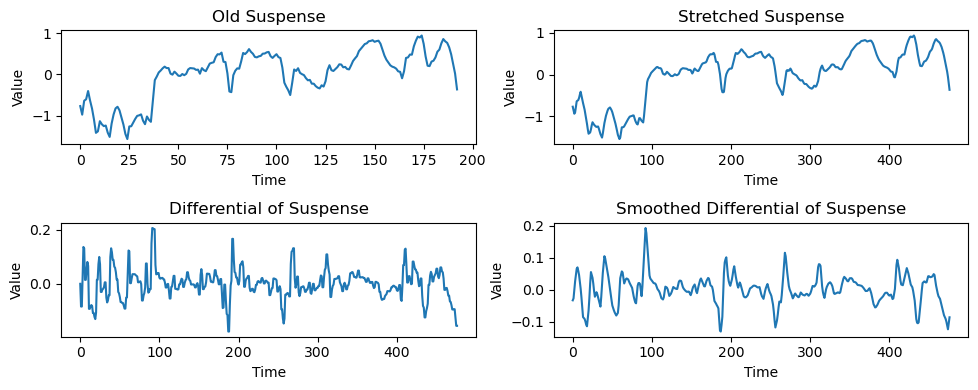

In [3]:
# 1. load suspense ratings, which are sampled every few seconds
old_suspense = np.load('./data_files/avg_suspense.npy')

# 2. stretch suspense, via interpolation, to match the movie length
old_ts, expanded_ts = np.linspace(0, 1, len(old_suspense)), np.linspace(0, 1, len(df_encoding['trial_smooth_spikes'].iloc[0]))
suspense_interpolate_fn = interp1d(old_ts, old_suspense, kind='linear', fill_value="extrapolate")
stretched_suspense = suspense_interpolate_fn(expanded_ts)

# 3. obtain differential of suspense
diff_suspense = np.diff(stretched_suspense)
diff_suspense = np.insert(diff_suspense, 0, 0)

# 4. smooth the differential using a moving average
smooth_diff_suspense = np.convolve(diff_suspense, np.ones(5) / 5, mode='same')
print(f'kernal thats being slid over: {np.ones(5) / 5}')

# plot
fig, axs = plt.subplots(2, 2, figsize=(10, 4))

titles = ['Old Suspense', 'Stretched Suspense', 'Differential of Suspense', 'Smoothed Differential of Suspense']
ts_data = [old_suspense, stretched_suspense, diff_suspense, smooth_diff_suspense]

for ax, title, values in zip(axs.flat, titles, ts_data):
    ax.plot(values)
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

## setting up some vars

In [4]:
num_bins = len(df_encoding['trial_smooth_spikes'].iloc[0])
x_time_points = np.linspace(1, np.max(df_encoding['RT']), num_bins)
color_map = {'ACC': 'purple', 'amygdala': 'green', 'hippocampus': 'blue', 'preSMA': 'red', 'vmPFC': 'orange'}

##  showing example neurons with 16s blocks of missing data

In [5]:
# session, region = 'P44CS_R1', 'amygdala'
# select_df = df_encoding[(df_encoding['sess'] == session) & (df_encoding['region'] == region)].reset_index(drop=True)

# RT = int(select_df['RT'].iloc[0])
# num_bins = len(df_encoding['trial_smooth_spikes'].iloc[0])
# x_time_points = np.linspace(1, RT, num_bins)

# block_sz = 16 # time blocks of neuron recordings
# x_ticks = np.arange(0, 2*len(select_df['trial_aligned_spikes'].iloc[0]), block_sz)

# for neur_i in range(len(select_df)):

#     t, spike_train = 0, np.array(select_df['trial_aligned_spikes'].iloc[neur_i])

#     print('no spikes in blocks: ', end='')
#     while True:
        
#         block_spikes = spike_train[(t <= spike_train) & (spike_train < t + block_sz)]
        
#         # if no spikes in 16s block
#         if not np.any(block_spikes):

#             # see how long until next spike, store that 'next' timepoint as t2
#             for t2 in range(t+block_sz, RT):

#                 bigger_block_spikes = spike_train[(t <= spike_train) & (spike_train < t2)]

#                 if np.any(bigger_block_spikes):
#                     print(f'{t}-{t2}', end=', ')
#                     t = t2-1 # -1 because t+=1 at end of loop
#                     break
        
#         t+=1
#         if t >= RT-block_sz:
#             break

#     plt.figure(figsize=(20,1))
#     plt.eventplot(select_df['trial_aligned_spikes'].iloc[neur_i], linelengths=0.8, color='black')
#     plt.xlabel('time')
#     plt.xticks(x_ticks)

#     plt.plot(x_time_points, select_df['trial_smooth_spikes'].iloc[neur_i])
#     plt.show()

#     # break



## drop neurons with >16s blocks of no spikes

In [6]:
neurs_to_drop = []
recording_block_sz = 16 # time chunks of recording neurons

# loop through each neuron row in df_encoding
for neur_idx, neur_row in df_encoding.iterrows():

    # get recording duration and spikes for the current neuron
    RT = int(neur_row['RT'])
    spike_train = np.array(neur_row['trial_aligned_spikes'])
    
    t1, toDrop = 0, False
    
    # go through trial to find empty blocks
    while t1 < RT - recording_block_sz:

        block_spikes = spike_train[(t1 <= spike_train) & (spike_train < t1 + recording_block_sz)]
        t2 = t1

        if not np.any(block_spikes):
            
            toDrop = True

            # find next t where spikes occurs, as this will mark the end of the empty block
            for t2 in range(t1 + recording_block_sz, RT):
                
                bigger_block_spikes = spike_train[(t1 <= spike_train) & (spike_train < t2)]
                if np.any(bigger_block_spikes):
                    break
                    
        if toDrop:
            neurs_to_drop.append(neur_idx)
            break

        t1 = t2+1

print(f'total neurons {len(df_encoding)}')
df_encoding = df_encoding.drop(neurs_to_drop).reset_index(drop=True)
print(f'retained neurons {len(df_encoding)}')
print(df_encoding.groupby('region').size())

total neurons 1438
retained neurons 1046
region
ACC            171
amygdala       329
hippocampus    193
preSMA         237
vmPFC          116
dtype: int64


## for each subject's 2 sessions, plot region-avged FRs

In [20]:
# regions_to_plot = ['amygdala']

# for subj, subj_df in df_encoding.groupby('subj'):

#     if not subj_df['region'].str.contains('|'.join(regions_to_plot)).any():
#         continue

#     fig, axs = plt.subplots(2, 1, figsize=(10, 4))
#     sess_num = 0

#     for session, session_df in subj_df.groupby('sess'):

#         # if not session in sessions_with_scene_cells:
#         #     continue

#         sess_minFR, sess_maxFR = 0, 0
#         print()
#         for region, region_df in session_df.groupby('region'):

#             if not region in regions_to_plot:
#                 continue

#             # convert groupby obj to 2d arr
#             smooth_spikes_arr = np.array(region_df['trial_smooth_spikes'].tolist())

#             # get the avg and std smoothed FR across neurons of a region  
#             smooth_FR_region_avg, smooth_FR_region_sd = np.nanmean(smooth_spikes_arr, axis=0), np.nanstd(smooth_spikes_arr, axis=0)

#             # to set ylim for plotting purposes, get the max and min FR across all regions
#             across_rgn_minFR = min(sess_minFR, np.nanmin(smooth_FR_region_avg))
#             across_rgn_maxFR = max(sess_maxFR, np.nanmax(smooth_FR_region_avg))

#             # plot FR
#             axs[sess_num].plot(x_time_points, smooth_FR_region_avg, label=region, color=color_map.get(region))
#             axs[sess_num].fill_between(x_time_points,
#                                        smooth_FR_region_avg - smooth_FR_region_sd, smooth_FR_region_avg + smooth_FR_region_sd,
#                                        alpha=0.1, color=color_map.get(region))

#             # plot suspense
#             # normalized_suspense = (suspense_ts - np.min(suspense_ts)) / (np.max(suspense_ts) - np.min(suspense_ts)) * (across_rgn_maxFR - across_rgn_minFR) + across_rgn_minFR
#             # axs[sess_num].plot(np.linspace(0, np.max(df_encoding['RT']), len(suspense_ts)), normalized_suspense, label='suspense', color='black')

#             normalized_suspense = (stretched_suspense - np.min(stretched_suspense)) / (np.max(stretched_suspense) - np.min(stretched_suspense)) * (across_rgn_maxFR - across_rgn_minFR) + across_rgn_minFR
#             axs[sess_num].plot(normalized_suspense, label='suspense', color='black')

#         # # make vertical lines at each scene cut
#         # for cut, color in zip(cuts_df['shot_start_t'], cuts_df['cut_colors']):
#         #     axs[sess_num].axvline(x=cut, color=color, linestyle='--')

#         if False: #subj in no_fMRI_subjs:
#             axs[sess_num].set_title(f'subj-{subj} sessions (DID NOT UNDERGO fMRI)', fontsize=16)
#         else:
#             axs[sess_num].set_title(f'subj-{subj} session {session.split("R")[1][0]} ({smooth_spikes_arr.shape[0]} neurons)', fontsize=16)

#         axs[sess_num].set_xlabel('time (s) across film', fontsize=12)
#         axs[sess_num].set_ylabel('normalized FR', fontsize=12)
#         axs[sess_num].set_ylim(across_rgn_minFR, across_rgn_maxFR)
#         axs[sess_num].legend(loc='upper right')

#         sess_num += 1

#     plt.tight_layout()  
#     plt.show()



## inspecting a particular session

In [19]:
# session, region = 'P56CS_R2', 'amygdala'

# select_df = df_encoding[(df_encoding['sess'] == session) & (df_encoding['region'] == region)].reset_index(drop=True)

# # get population time series, and mean & sd
# neur_by_time = np.array(select_df['trial_smooth_spikes'].tolist())
# neur_by_time_avg, neur_by_time_sd = np.nanmean(neur_by_time, axis=0), np.nanstd(neur_by_time, axis=0) 

# fig = plt.figure(figsize=(8, 2))
# plt.plot(x_time_points, neur_by_time_avg, label=region, color=color_map.get(region))
# plt.fill_between(x_time_points,
#                  neur_by_time_avg - neur_by_time_sd, neur_by_time_avg + neur_by_time_sd,
#                  alpha=.1, color=color_map.get(region))

# # plot suspense
# min_fr, max_fr = -2, 2 #np.nanmin(neur_by_time_avg), np.nanmax(neur_by_time_avg)

# normalized_suspense = (stretched_suspense - np.min(stretched_suspense)) / (np.max(stretched_suspense) - np.min(stretched_suspense)) * (max_fr - min_fr) + min_fr
# # plt.plot(normalized_suspense, label='suspense', color='black')

# # # now plot normalized_diff_supsense too
# normed_smooth_diff_suspense = (smooth_diff_suspense - np.min(smooth_diff_suspense)) / (np.max(smooth_diff_suspense) - np.min(smooth_diff_suspense)) * (max_fr - min_fr) + min_fr
# plt.plot(normed_smooth_diff_suspense, label='diff_suspense', color='black')

# # plt.legend(loc='upper left')
# plt.xlabel('time (s) across film', fontsize=14)#, fontname='Arial')
# plt.ylabel('normalized FR\n(Hz)', fontsize=14)#, fontname='Arial')
# plt.ylim(min_fr-.5, max_fr+.5)
# plt.tick_params(axis='both', length=0)
# for spine in plt.gca().spines.values():
#     spine.set_linewidth(1.5)
# plt.title(f'{region} ({neur_by_time.shape[0]} neurons)', fontsize=22)
# plt.tight_layout()
# plt.savefig(f'data_files/{session}_{region}_{neur_by_time.shape[0]}_neurons.svg', format='svg', dpi=300)
# plt.show()

# # fig, axs = plt.subplots(neur_by_time.shape[0], 1, figsize=(10, 20))

# # for i in range(neur_by_time.shape[0]):
# #     axs[i].plot(x_time_points, neur_by_time[i], label=f'Neuron {i+1}')
# #     axs[i].set_title(f'Time Series of Neuron {i+1}')
# #     axs[i].set_ylim(-2, max(4, max(neur_by_time[i])))

# # plt.tight_layout()
# # plt.show()

## sliding window PCA to plot % explained by top PCs

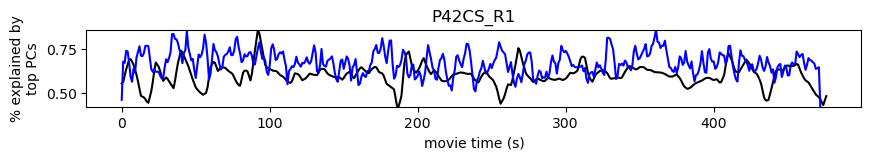

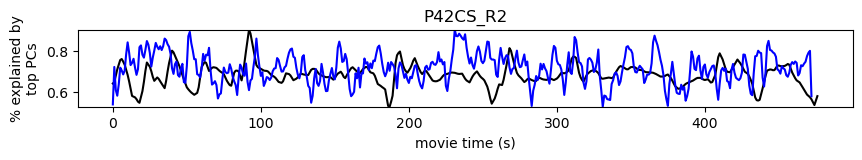

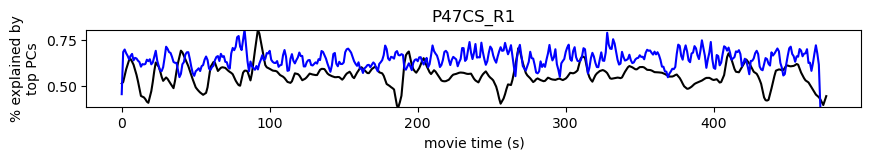

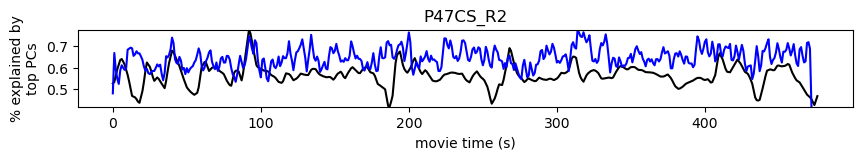

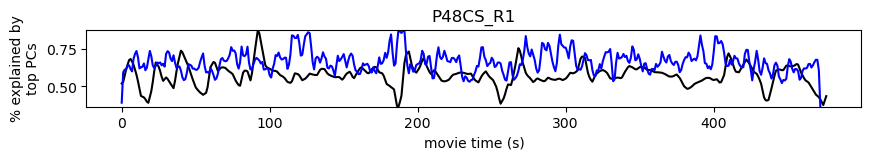

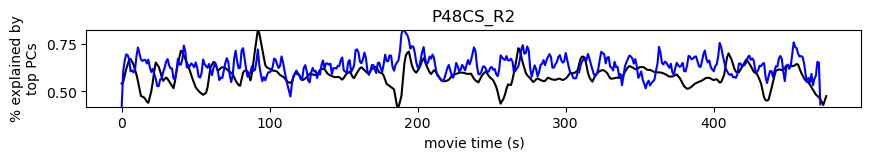

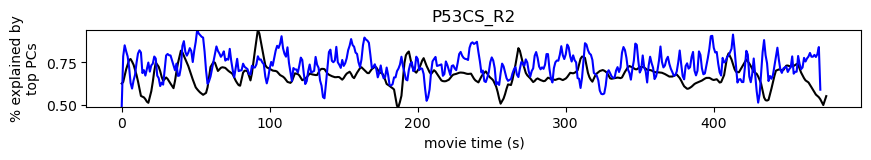

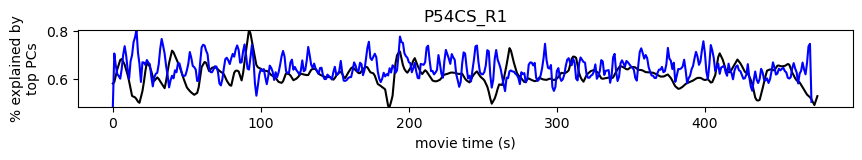

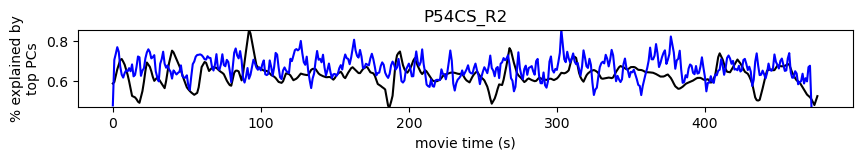

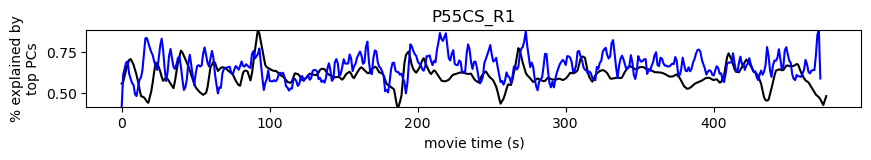

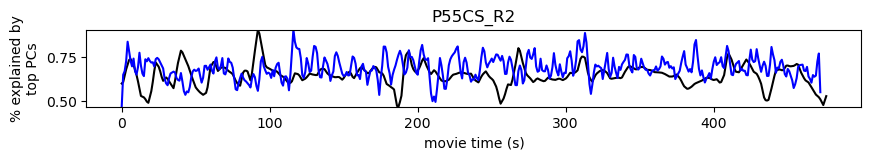

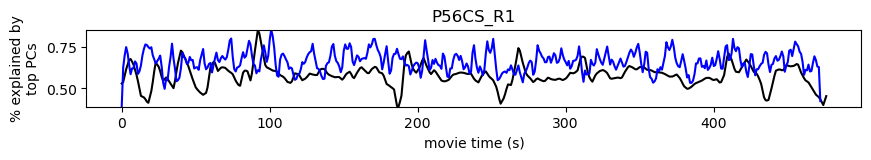

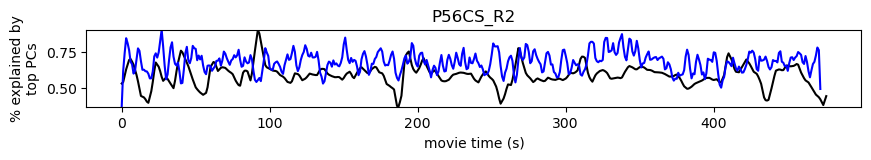

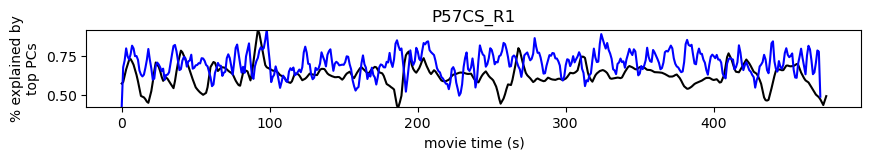

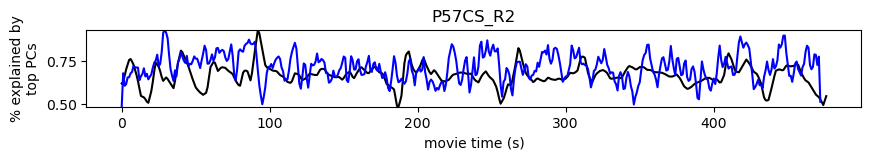

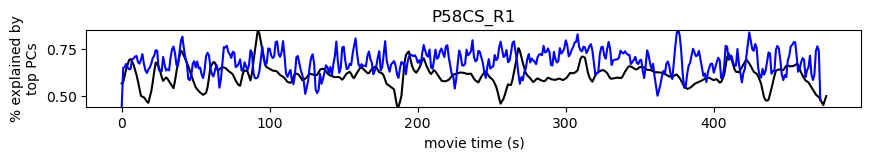

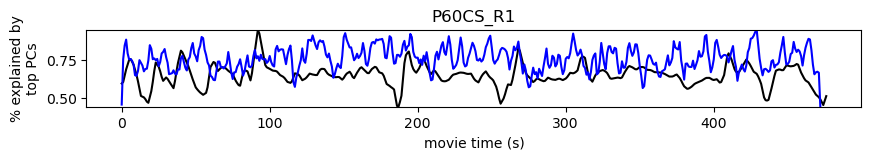

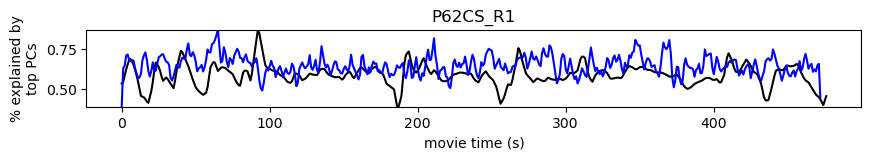

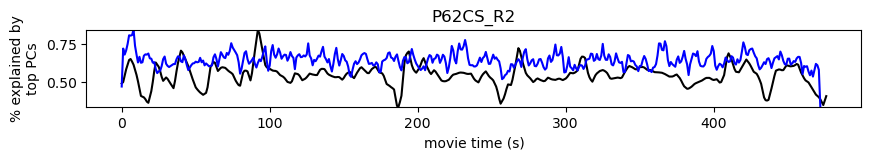

In [56]:
df_region = df_encoding[df_encoding['region'] == 'amygdala']
win_size = 5

for session, session_df in df_region.groupby('sess'):

    if len(session_df) < 5: # only consider sessions with >5 neurons in region
        continue

    # convert groupby obj to 2d array
    neur_by_time = np.array(session_df['trial_smooth_spikes'].tolist())
    num_neurons, num_timepoints = neur_by_time.shape

    var_explained_by_top_PCs = []
    # slide window
    for start in range(0, num_timepoints - win_size + 1):

        window_data = neur_by_time[:, start:start + win_size]
        
        pca = PCA()
        pca.fit(window_data.T)
        
        # append % explained by top 2 PCs
        var_explained_by_top_PCs.append(np.sum(np.sort(pca.explained_variance_ratio_)[-1:]))

    var_explained_by_top_PCs = np.convolve(var_explained_by_top_PCs, np.ones(3)/3, mode='same')

    min_var, max_var = np.min(var_explained_by_top_PCs), np.max(var_explained_by_top_PCs)
    normed_suspense = (stretched_suspense - np.min(stretched_suspense)) / (np.max(stretched_suspense) - np.min(stretched_suspense)) * (max_var - min_var) + min_var
    normed_smooth_diff_suspense = (smooth_diff_suspense - np.min(smooth_diff_suspense)) / (np.max(smooth_diff_suspense) - np.min(smooth_diff_suspense)) * (max_var - min_var) + min_var

    plt.figure(figsize=(10, 1))
    plt.plot(normed_smooth_diff_suspense, label='suspense', color='black')

    timepoints = np.arange(0, num_timepoints - win_size + 1) 
    plt.plot(timepoints, var_explained_by_top_PCs, color='blue', label="Variance Explained by Top 3 Neurons")

    plt.xlabel('movie time (s)')
    plt.ylabel('% explained by\ntop PCs')
    plt.ylim(min_var, max_var)
    # plt.legend()
    plt.title(f'{session}')
    plt.show()


## for all sessions, plot amygdala sliding PCA

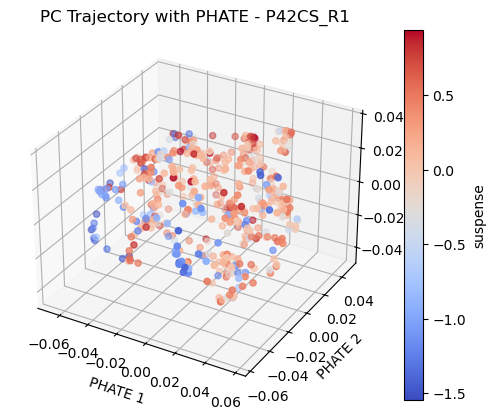

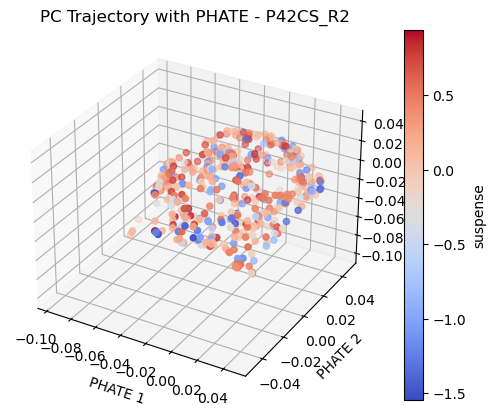

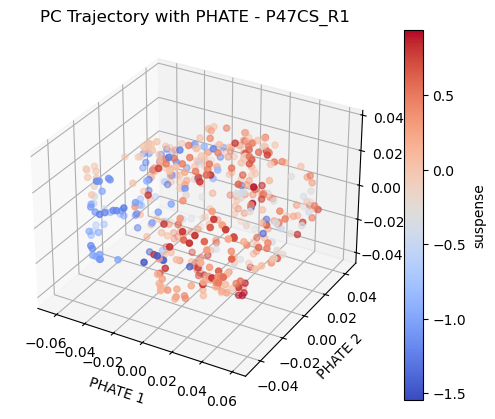

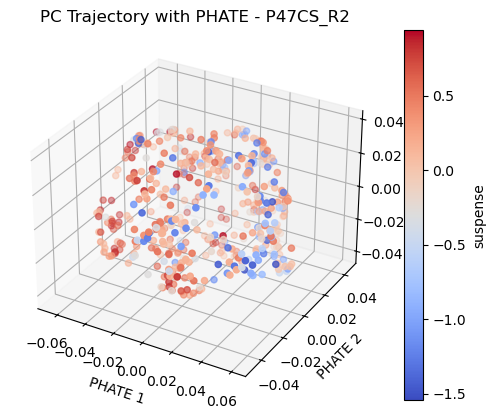

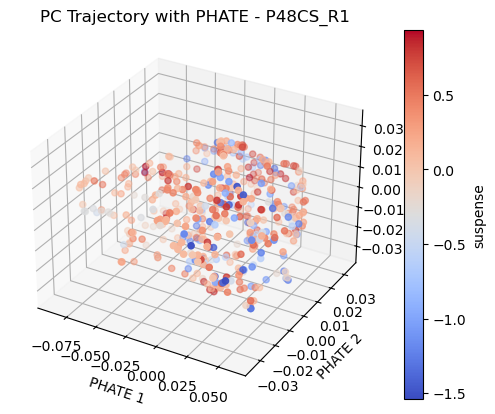

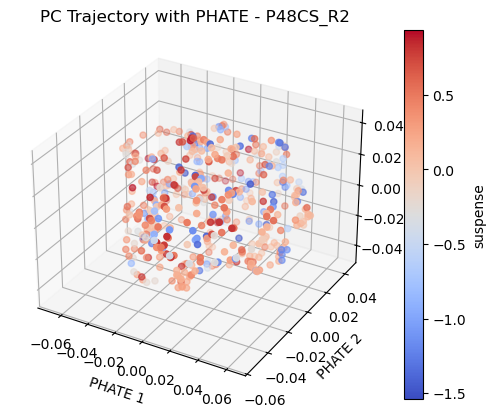

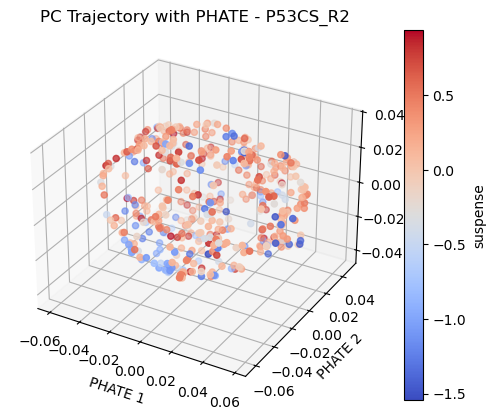

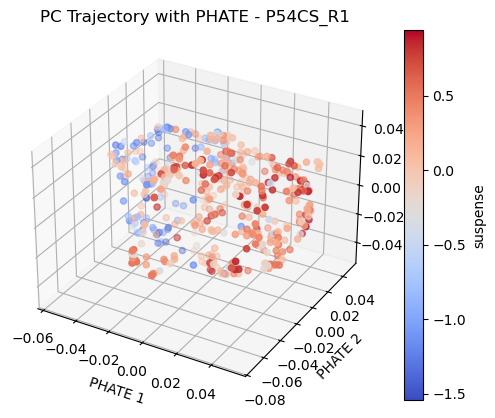

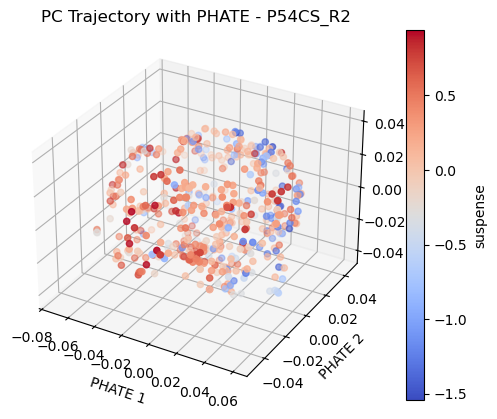

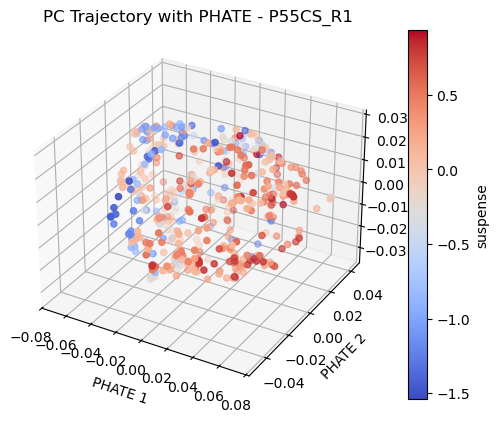

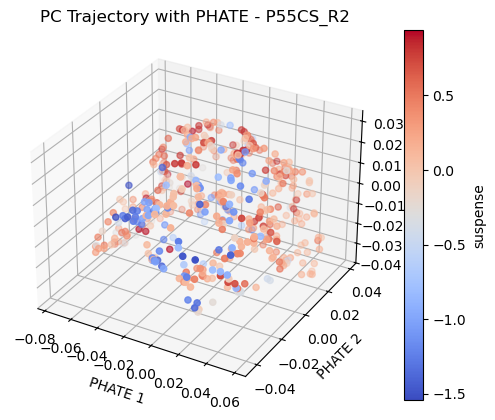

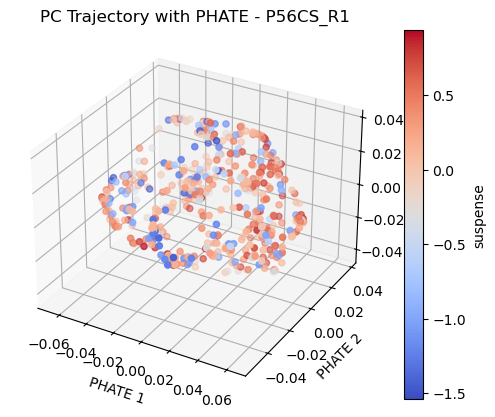

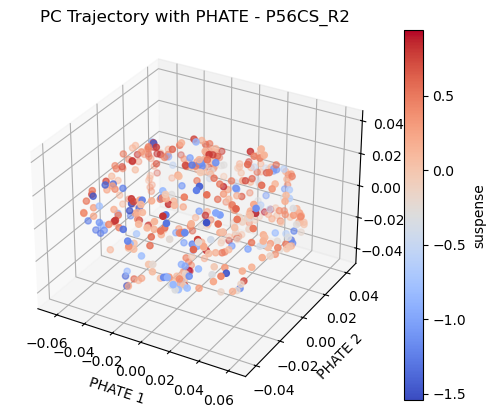

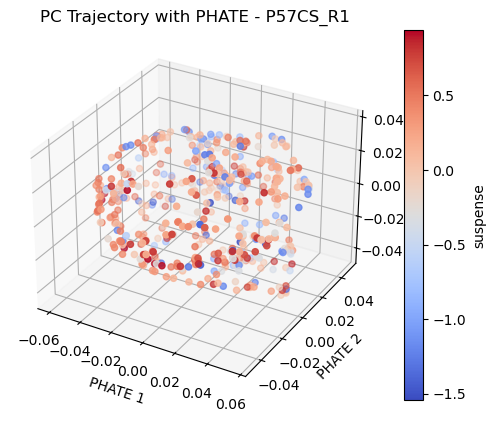

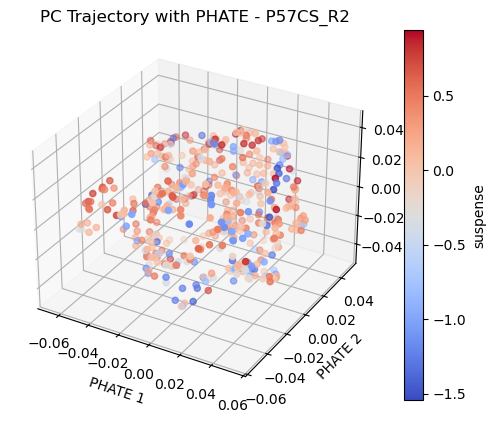

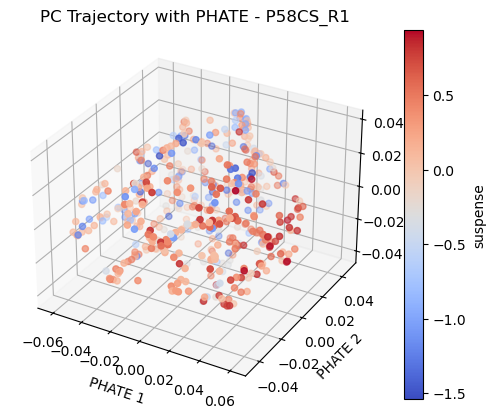

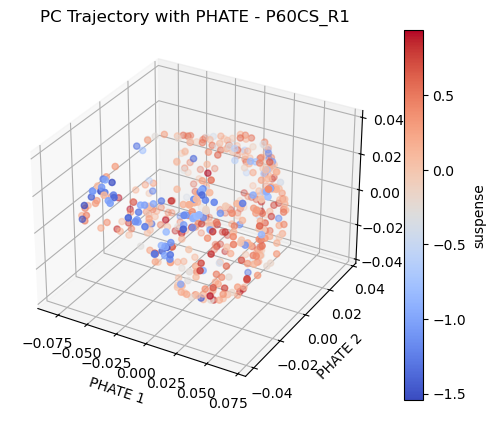

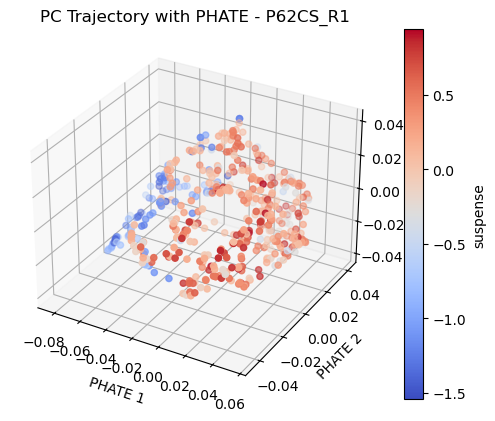

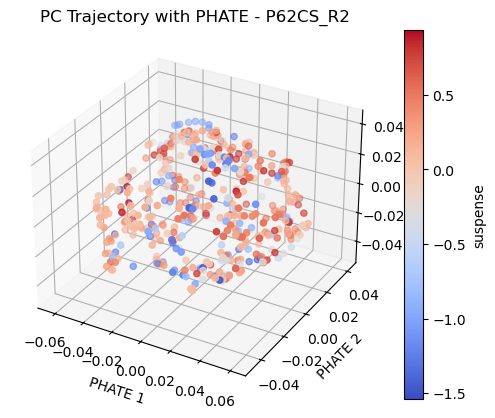

In [58]:
df_region = df_encoding[df_encoding['region'] == 'amygdala']
sess_num = 0

for session, session_df in df_region.groupby('sess'):

    if len(session_df) < 5:
        continue

    subj = session.split('CS')[0]

    # convert groupby obj to 2d arr
    neur_by_time_arr = np.array(session_df['trial_smooth_spikes'].tolist())

    # peform PCA
    pca = PCA(n_components=3)  # start with a few PCs
    pc_scores = pca.fit_transform(neur_by_time_arr.T) # get time by PC

    # apply PHATE on PCA-reduced data
    phate_operator = phate.PHATE(n_components=3, verbose=False)  # Set to 3 components for 3D
    phate_embedding = phate_operator.fit_transform(pc_scores)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # plot the PHATE embedding (3D scatter plot)
    scatter = ax.scatter(phate_embedding[:, 0], phate_embedding[:, 1], phate_embedding[:, 2], c = stretched_suspense, cmap="coolwarm")
    # scatter = ax.scatter(phate_embedding[:, 0], phate_embedding[:, 1], phate_embedding[:, 2], c = smooth_diff_suspense, cmap="coolwarm")

    ax.set_xlabel("PHATE 1")
    ax.set_ylabel("PHATE 2")
    ax.set_zlabel("PHATE 3")
    ax.set_title(f"PC Trajectory with PHATE - {session}")

    plt.colorbar(scatter, label="suspense")
    # plt.colorbar(scatter, label="smoothed differential of suspense")
    plt.show()

    sess_num += 1




## for all sessions, plot amygdala t-phate

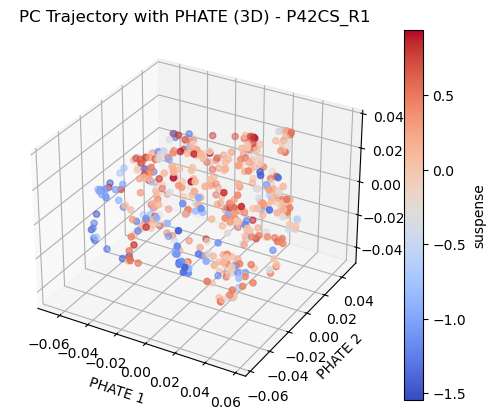

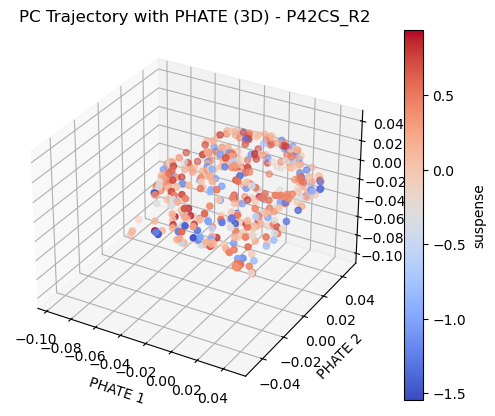

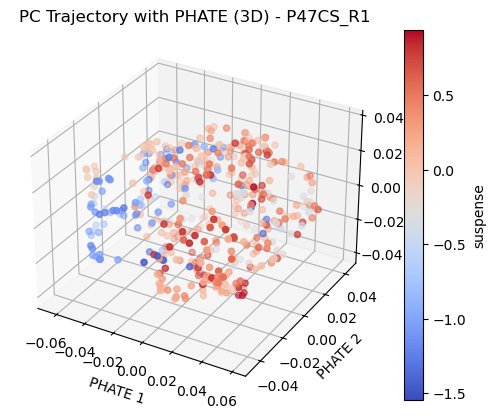

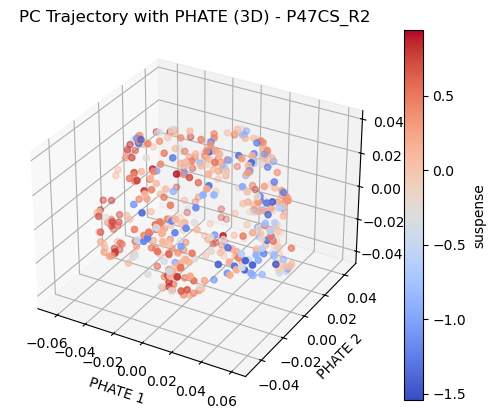

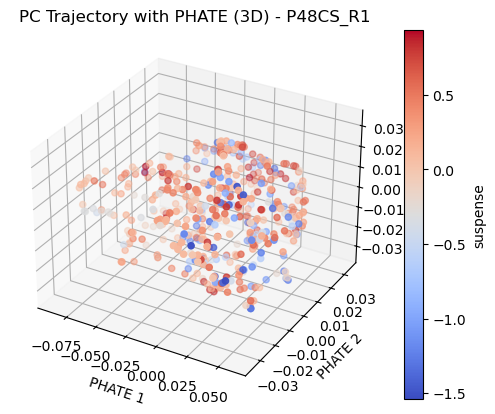

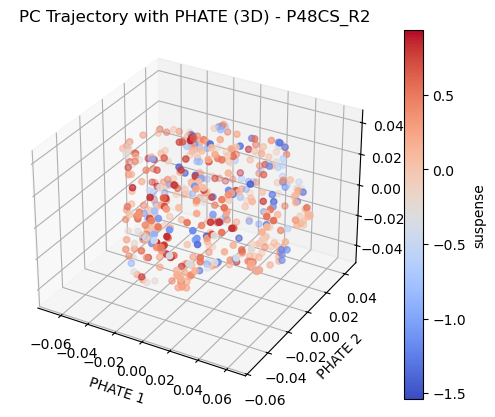

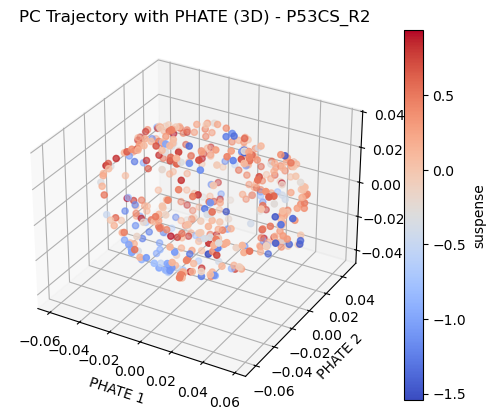

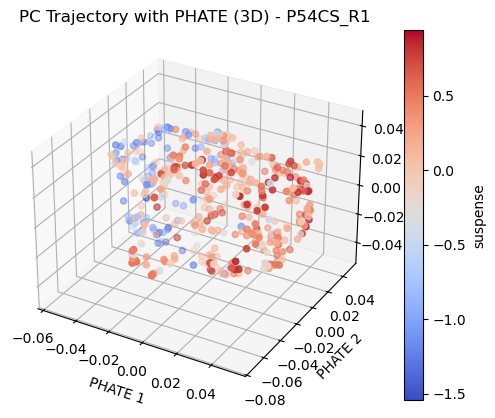

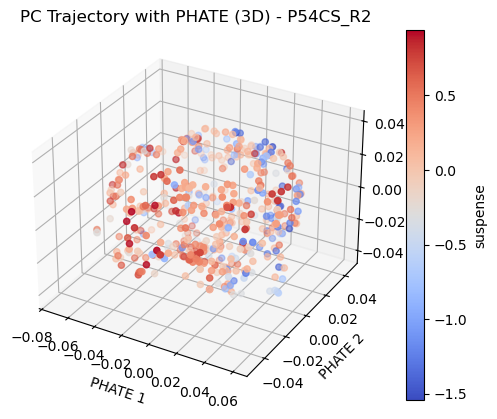

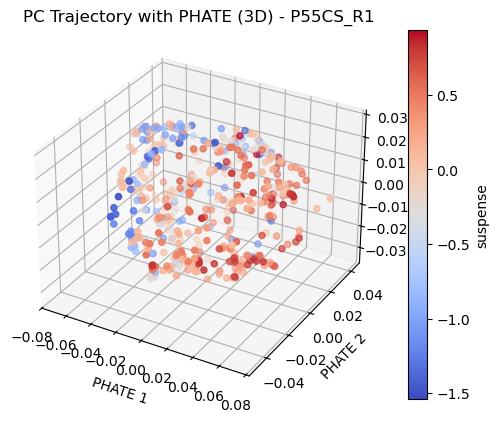

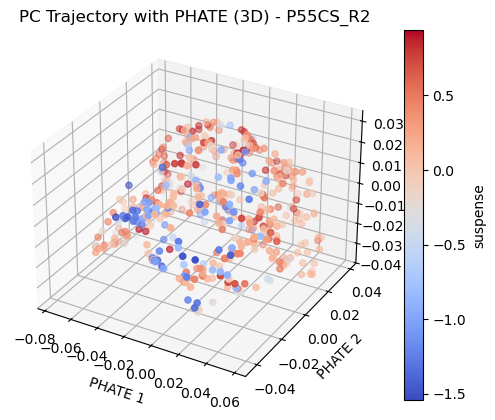

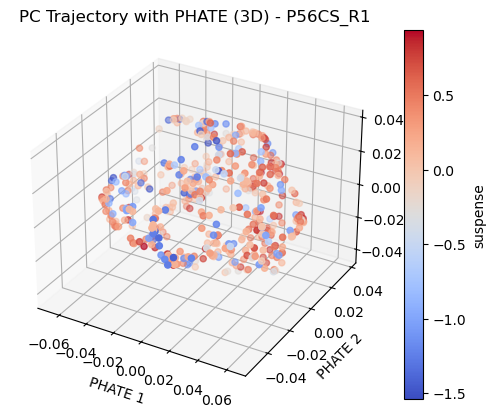

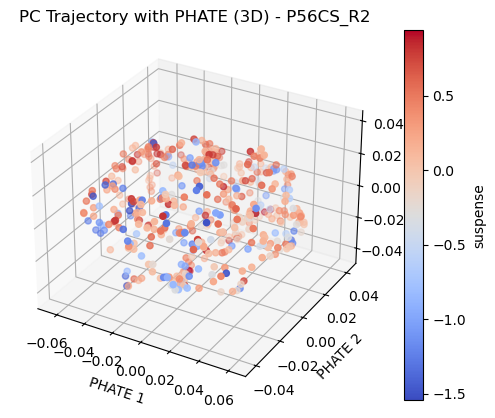

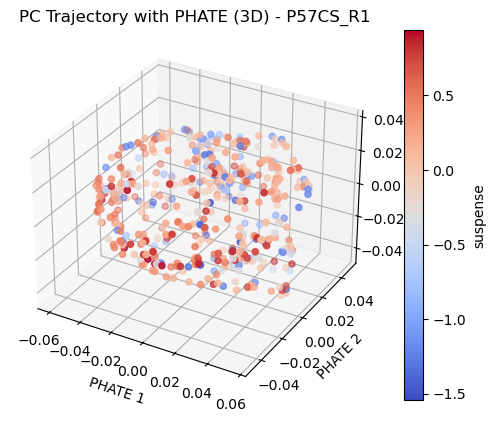

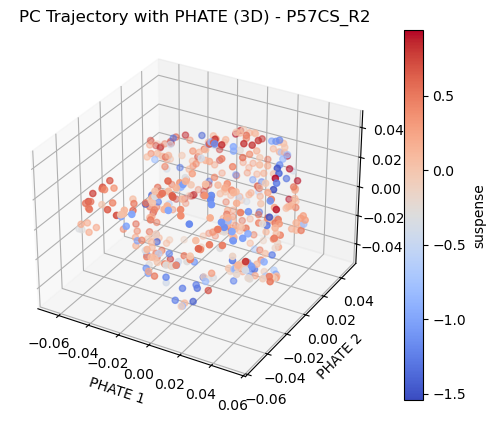

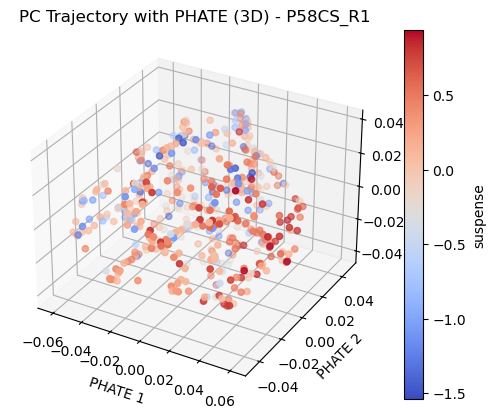

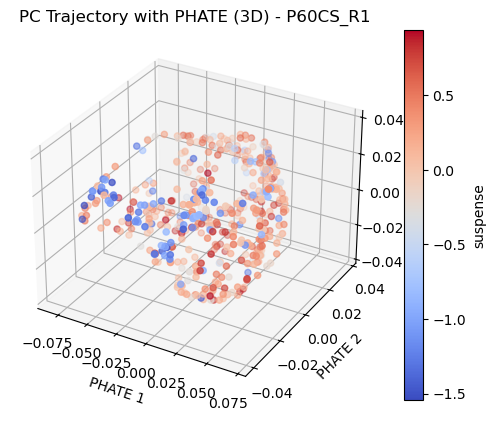

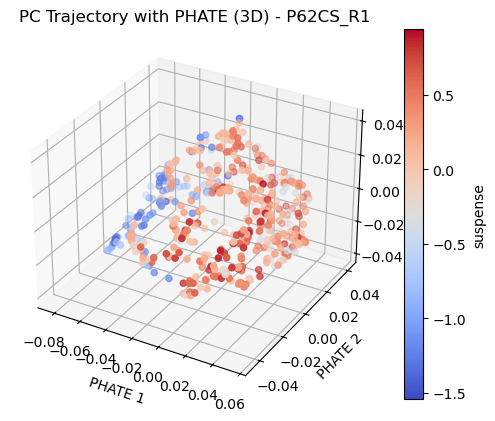

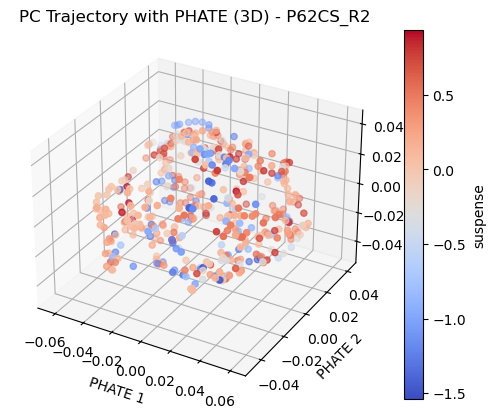

In [21]:
df_region = df_encoding[df_encoding['region'] == 'amygdala']
sess_num = 0

for session, session_df in df_region.groupby('sess'):

    if len(session_df) < 5:
        continue

    subj = session.split('CS')[0]

    # convert groupby obj to 2d arr
    neur_by_time = np.array(session_df['trial_smooth_spikes'].tolist())

    # peform PCA
    pca = PCA(n_components=3)  # start with a few PCs
    pc_scores = pca.fit_transform(neur_by_time.T) # get time by PC

    # apply PHATE on PCA-reduced data
    phate_operator = phate.PHATE(n_components=3, verbose=False)  # Set to 3 components for 3D
    phate_embedding = phate_operator.fit_transform(pc_scores)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # plot the PHATE embedding (3D scatter plot)
    scatter = ax.scatter(phate_embedding[:, 0], phate_embedding[:, 1], phate_embedding[:, 2], c = stretched_suspense, cmap="coolwarm")
    # scatter = ax.scatter(phate_embedding[:, 0], phate_embedding[:, 1], phate_embedding[:, 2], c = smooth_diff_suspense, cmap="coolwarm")

    ax.set_xlabel("PHATE 1")
    ax.set_ylabel("PHATE 2")
    ax.set_zlabel("PHATE 3")
    ax.set_title(f"PC Trajectory with PHATE (3D) - {session}")

    plt.colorbar(scatter, label="suspense")
    # plt.colorbar(scatter, label="smoothed differential of suspense")
    plt.show()

    sess_num += 1




## neurons sorted by PCA

In [ ]:
# [10  4 11  1  6  5  9  3  0  7  8 12  2] # sess_baseline
# [ 2  9  5  0  6  8  1  3  7  4 12 10 11] # shortest_baseline
# [ 5  1  9  4  8 10  3  6 11  0  7 12  2] # self


## get scene cut info

In [ ]:
# cuts_df = pd.read_csv('../assets/annotations/scenecut_info.csv')
# cuts = cuts_df['shot_start_t'].tolist()

# # 1st frame is always a scene cut
# scene_cut_inds = [0]
# # find the indices of scene cuts
# scene_cut_inds.extend(np.where(np.diff(cuts_df['scene_id']) != 0)[0] + 1)

# print(f'{len(scene_cut_inds)} scene cuts at indices {scene_cut_inds}')

# cuts_df['cut_colors'] = 'grey'
# cuts_df.loc[scene_cut_inds, 'cut_colors'] = 'red'
# cuts_df.head(15)

## plot some of the scene selective cells that they found

'Significant proportions of cells were event selective in the vmPFC (10/175, p =  0.005, permutation test) and preSMA (20/299,  p <  0.001) but not in the amygdala (15/479, p =  0.081), ACC (7/236, p =  0.224), and hippocampus (8/261, p = 0.199;  Fig. 7a,b show examples).'

In [ ]:
# print('plotting the 60 scene selective cells that they found')

# for neuron in scene_cells[:5]:

#     print(neuron[1:3], end=', ')
#     neuron_df = df_encoding[df_encoding['neuron'] == neuron]

#     # get the length of the first spike array
#     num_bins = len(neuron_df['trial_smooth_spikes'].iloc[0])
#     x_time_points = np.linspace(1, np.max(neuron_df['RT']), num_bins)
#     print(len(x_time_points))
#     plt.figure(figsize=(20, 3))
#     plt.plot(x_time_points, neuron_df['trial_smooth_spikes'].iloc[0], label=neuron)

#     for cut, color in zip(cuts_df['shot_start_t'], cuts_df['cut_colors']):
#         plt.axvline(x=cut, color=color, linestyle='--')

    
#     plt.xlabel('time (s) across film')
#     plt.ylabel('normalized FR')
#     plt.title(f'neuron {neuron}')
#     plt.ylim(-2, 5)
#     plt.axhline(0, color='grey', linestyle='--')
#     plt.tight_layout()
# plt.show()


## plot single session scene cut plus FR info 

In [ ]:
# session, region = 'P57CS_R2', 'amygdala'

# P44CS_R1_ACC_df = df_encoding[(df_encoding['sess'] == session) & (df_encoding['region'] == region)].reset_index(drop=True)
# neur_by_time = np.array(P44CS_R1_ACC_df['trial_smooth_spikes'].tolist())
# print(neur_by_time.shape)

# neur_by_time_avg, neur_by_time_sd = np.nanmean(neur_by_time, axis=0), np.nanstd(neur_by_time, axis=0) 

# fig = plt.figure(figsize=(10, 2))
# plt.plot(x_time_points, neur_by_time_avg, label=region, color=color_map.get(region))
# plt.fill_between(x_time_points,
#                  neur_by_time_avg - neur_by_time_sd, neur_by_time_avg + neur_by_time_sd,
#                  alpha=0.1, color=color_map.get(region))

# # # make vertical lines at each scene cut
# # for cut, color in zip(cuts_df['shot_start_t'], cuts_df['cut_colors']):
# #     plt.axvline(x=cut, color=color, linestyle='--')

# plt.xlabel('time (s) across film', fontsize=12)
# plt.ylabel('normalized FR', fontsize=12)
# plt.ylim(-2, 4)
# plt.legend(loc='upper right')

# plt.tight_layout()
# plt.show()


# # convert to np array and hand select a period of FR ramp-up
# neur_by_time = np.array(P44CS_R1_ACC_df['trial_smooth_spikes'].tolist())

# pca = PCA()
# pca.fit(neur_by_time.T)

# first_pc_loadings = pca.components_[0]
# neurs_sorted_by_pc1 = np.argsort(np.abs(first_pc_loadings))[::-1]

# neur_by_time = neur_by_time[neurs_sorted_by_pc1]
# top_neur_by_time = neur_by_time[:3]

# # print(f'1st pc loadings: {first_pc_loadings}')
# # print(f'sorted neurons: {neurs_sorted_by_pc1}')
# # print(top_neur_by_time.shape)

# fig, axs = plt.subplots(top_neur_by_time.shape[0], 1, figsize=(10, 5))

# for i in range(top_neur_by_time.shape[0]):
#     axs[i].plot(top_neur_by_time[i], label = neurs_sorted_by_pc1[i])
#     axs[i].set_ylim(-2, max(4, max(top_neur_by_time[i])))
#     axs[i].legend()
# plt.tight_layout()
# plt.show()

